In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf
from scipy.stats import norm
from scipy.stats import gaussian_kde
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(t,N,D,w0,L):
    nmax = 5
    n = np.arange(1,nmax)
    nn,tt = np.meshgrid(n,t)
    
    efa = nn*np.pi*w0**2*1j
    an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    return np.sum(an,axis=1)/N/2

In [3]:
dt = 0.1
D = 1.0
L = 10
#xl = 5.0
#xr = 6.0
N = 20
length = 100000

In [4]:
acf_all=None
for i in range(2000):
    # generate steps for all particles
    steps=np.random.normal(loc=0.0, scale=np.sqrt(2*D*dt), size=(N,length))
    # initial positions
    x = 2*L*np.random.random(size=(N,))
    # put initial position in front
    x = np.column_stack((x, steps))
    # calculate paths
    paths = np.mod(np.cumsum(x, axis=1),2*L)-L
    # place a Gaussian illumination at x=5.5 with unit variance
    intensity = norm.pdf(paths, loc=0)
    intensity = np.sum(intensity, axis=0)

    # calculate autocorrelation function
    f = np.fft.rfft(intensity)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / length
    autocorr = acf[int(length/2):]/intensity.mean()**2

    autocorr = autocorr[:1000]-1.0
    t = np.arange(0,autocorr.size)*dt
    
    if acf_all is None:
        acf_all = autocorr
    else:
        acf_all = np.vstack((acf_all, autocorr))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

17254.993994510958 0.03112297361110591 93.78605859145605


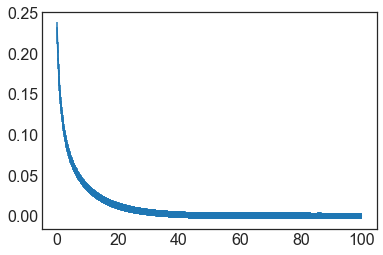

In [36]:
plt.errorbar(t,acf_mean,yerr=acf_std)
relerror=acf_std/np.abs(acf_mean)
print(relerror.max(),relerror.min(),relerror.mean())

In [6]:
N_list=[]
D_list=[]
dN_list=[]
dD_list=[]

NS_list=[]
DS_list=[]
dNS_list=[]
dDS_list=[]

corrfitPB_model=lm.Model(corrfitPB)

for y in acf_all:
    paramsPB = corrfitPB_model.make_params()
    paramsPB['w0'].set(value=1,vary=False)
    paramsPB['N'].set(value=20,vary=True)
    paramsPB['D'].set(value=D,vary=True)
    paramsPB['L'].set(value=L,vary=False)

    resultPB = corrfitPB_model.fit(t=t,data=y,params=paramsPB)
    
    N_list.append(resultPB.values['N'])
    D_list.append(resultPB.values['D'])
    dN_list.append(np.sqrt(resultPB.covar[0,0]))
    dD_list.append(np.sqrt(resultPB.covar[1,1]))
                   
    paramsPBS = corrfitPB_model.make_params()
    paramsPBS['w0'].set(value=1,vary=False)
    paramsPBS['N'].set(value=20,vary=True)
    paramsPBS['D'].set(value=D,vary=True)
    paramsPBS['L'].set(value=L,vary=False)

    resultPBS = corrfitPB_model.fit(t=t,data=y,weights=1/acf_std,params=paramsPBS)
    
    NS_list.append(resultPBS.values['N'])
    DS_list.append(resultPBS.values['D'])
    dNS_list.append(np.sqrt(resultPBS.covar[0,0]))
    dDS_list.append(np.sqrt(resultPBS.covar[1,1]))


In [7]:
N_list = np.array(N_list)
dN_list = np.array(dN_list)
D_list = np.array(D_list)
dD_list = np.array(dD_list)

NS_list = np.array(NS_list)
dNS_list = np.array(dNS_list)
DS_list = np.array(DS_list)
dDS_list = np.array(dDS_list)

1.0010724956281163 0.11678649269008266
1.364206854567564 0.16737579574217296


/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


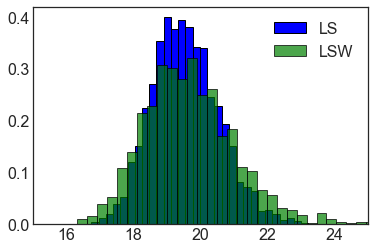

In [8]:
plt.hist(N_list,bins=30,normed=True,color="blue",edgecolor="k",label="LS")
plt.hist(NS_list,bins=30,normed=True,color="green",edgecolor="k",alpha=0.7,label="LSW")
plt.xlim((15,25))
plt.legend()
print(N_list.std(),dN_list.mean())
print(NS_list.std(),dNS_list.mean())

1.0447004095863504 0.1315085395806492 0.009927965447740335
1.0389749953018672 0.15261753125233832 0.011802034765279813


/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


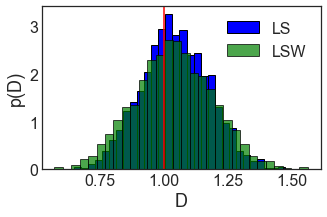

In [9]:
plt.figure(figsize=(5, 3))
plt.hist(D_list,bins=30,normed=True,color="blue",edgecolor="k",label="LS")
plt.hist(DS_list,bins=30,normed=True,color="green",edgecolor="k",label="LSW",alpha=0.7)
plt.axvline(x=1.0,color="r")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend()
print(D_list.mean(),D_list.std(),dD_list.mean())
print(DS_list.mean(),DS_list.std(),dDS_list.mean())
#plt.savefig("FCS_D300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

1.0447004095863504 0.1315085395806492 0.009927965447740335
1.0389749953018672 0.15261753125233832 0.011802034765279813


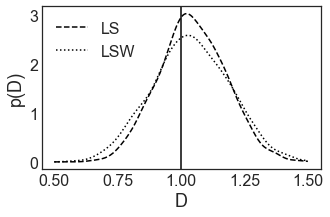

In [10]:
xd = np.linspace(0.5,1.5,200)
densityD = gaussian_kde(D_list)
densityDS = gaussian_kde(DS_list)
plt.figure(figsize=(5, 3))
plt.plot(xd,densityD(xd),"k--",label="LS")
plt.plot(xd,densityDS(xd),"k:",label="LSW")
plt.axvline(x=1.0,color="k")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend()
print(D_list.mean(),D_list.std(),dD_list.mean())
print(DS_list.mean(),DS_list.std(),dDS_list.mean())
#plt.savefig("FCS_D300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

1.2255117560623108 0.06273291556242136 0.007318508116798695
1.2330381752581028 0.08548898685261193 0.010488722552404843


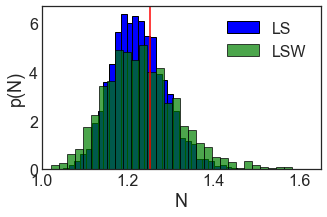

In [11]:
# instead of fitting how many particles per box N, we want to measure how many particles per focus
# size of focus is sqrt(pi/2)*w = 1.25
F_list = N_list/20.0*np.sqrt(np.pi/2)
dF_list = dN_list/20.0*np.sqrt(np.pi/2)
FS_list = NS_list/20.0*np.sqrt(np.pi/2)
dFS_list = dNS_list/20.0*np.sqrt(np.pi/2)

plt.figure(figsize=(5, 3))
plt.hist(F_list,bins=30,density=True,color="blue",edgecolor="k",label="LS")
plt.hist(FS_list,bins=30,density=True,color="green",edgecolor="k",alpha=0.7,label="LSW")
plt.axvline(x=np.sqrt(np.pi/2),color="r")
plt.legend()
plt.xlim((1,1.65))
plt.xlabel("N")
plt.ylabel("p(N)")
print(F_list.mean(),F_list.std(),dF_list.mean())
print(FS_list.mean(),FS_list.std(),dFS_list.mean())
#plt.savefig("FCS_N300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

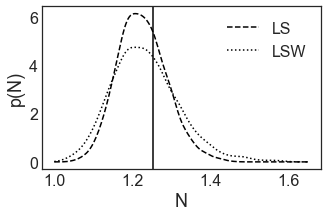

In [12]:
xn = np.linspace(1,1.65,200)
densityF = gaussian_kde(F_list)
densityFS = gaussian_kde(FS_list)
plt.figure(figsize=(5, 3))
plt.plot(xn,densityF(xn),"k--",label="LS")
plt.plot(xn,densityFS(xn),"k:",label="LSW")
plt.axvline(x=np.sqrt(np.pi/2),color="k")
plt.xlabel("N")
plt.ylabel("p(N)")

plt.legend()
#plt.savefig("FCS_N300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [13]:
#find out whether the means are ok
stderr = np.sqrt(N_list.size)
print(D_list.mean(),D_list.std(),dD_list.mean(),D_list.std()/stderr)
print(DS_list.mean(),DS_list.std(),dDS_list.mean(),DS_list.std()/stderr)
print(F_list.mean(),F_list.std(),dF_list.mean(),F_list.std()/stderr)
print(FS_list.mean(),FS_list.std(),dFS_list.mean(),FS_list.std()/stderr)

1.0447004095863504 0.1315085395806492 0.009927965447740335 0.002940620341240533
1.0389749953018672 0.15261753125233832 0.011802034765279813 0.0034126317443842705
1.2255117560623108 0.06273291556242136 0.007318508116798695 0.001402750636243286
1.2330381752581028 0.08548898685261193 0.010488722552404843 0.0019115918593002605


In [37]:
N_list2=[]
D_list2=[]
dN_list2=[]
dD_list2=[]

NS_list2=[]
DS_list2=[]
dNS_list2=[]
dDS_list2=[]

w0 = 1.0
L = 10.0
nmax = 5
n = np.arange(1,nmax)
nn,tt = np.meshgrid(n,t)
    
efa = nn*np.pi*w0**2*1j
an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))

def residual(pars, x, data=None, eps=None):
    # unpack parameters: extract .value attribute for each parameter
    parvals = pars.valuesdict()
    N = parvals['N']
    D = parvals['D']

    ann = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    model = np.sum(ann,axis=1)/N/2

    if data is None:
        return model
    if eps is None:
        return model - data
    return (model-data) / eps

for y in acf_all:
    pars = lm.Parameters()
    pars.add_many(('D', 1), ('N', 20))

    result = lm.minimize(residual, pars,kws = {'x':t,'data':y,'eps':acf_std})
    result.params.add('__lnsigma', value=np.log(100), min=np.log(0.01), max=np.log(20000))
    res = lm.minimize(residual, kws = {'x':t,'data':y,'eps':acf_std},method='emcee', nan_policy='omit', burn=300, steps=1000, thin=20,
                     params=result.params,is_weighted=False)

    print(lm.fit_report(result.params))
    N_list2.append(result.params.valuesdict()['N'])
    D_list2.append(result.params.valuesdict()['D'])
    dD_list2.append(np.sqrt(result.covar[0,0]))
    dN_list2.append(np.sqrt(result.covar[1,1]))
    print(N_list2[-1],D_list2[-1],dN_list2[-1],dD_list2[-1])

    NS_list2.append(res.flatchain['N'].mean())
    DS_list2.append(res.flatchain['D'].mean())
    dNS_list2.append(res.flatchain['N'].std())
    dDS_list2.append(res.flatchain['D'].std())
    print(NS_list2[-1],DS_list2[-1],dNS_list2[-1],dDS_list2[-1])
    



/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
  1%|          | 6/1000 [00:00<00:16, 58.99it/s]

[[Variables]]
    D:          0.85571348 +/- 0.00927082 (1.08%) (init = 1)
    N:          20.8561226 +/- 0.16991016 (0.81%) (init = 20)
    __lnsigma:  4.60517019 (init = 4.60517)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.85612259027915 0.8557134809344367 0.16991016459497124 0.009270816938191252
2.814068858260597 1.5066639861166329 107.39954274032605 3.8879122551595855


  1%|          | 6/1000 [00:00<00:16, 58.78it/s]

[[Variables]]
    D:          0.67923337 +/- 0.00702618 (1.03%) (init = 1)
    N:          23.5700189 +/- 0.18299779 (0.78%) (init = 20)
    __lnsigma:  4.60517019 (init = 4.60517)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
23.5700188565184 0.679233374549748 0.18299778834197125 0.007026175618060636
23.570652007561385 0.679404975809769 0.196864641477683 0.007798175049100419


 41%|████      | 412/1000 [00:06<00:09, 60.47it/s]Traceback (most recent call last):
  File "/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/emcee/ensemble.py", line 546, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/lmfit/minimizer.py", line 2206, in _lnpost
    out = userfcn(params, *userargs, **userkwargs)
  File "<ipython-input-37-4b8f99ebf2e4>", line 26, in residual
    ann = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
KeyboardInterrupt
 42%|████▏     | 417/1000 [00:06<00:09, 60.35it/s]

emcee: Exception while calling your likelihood function:
  params: [ 1.07231497 19.96257297 -0.38589136]
  args: (<function residual at 0x7fec18e16268>, Parameters([('D', <Parameter 'D', 1.0723149650163684, bounds=[-inf:inf]>), ('N', <Parameter 'N', 19.962572970225146, bounds=[-inf:inf]>), ('__lnsigma', <Parameter '__lnsigma', -0.38589135915079054, bounds=[-4.605170185988091:9.903487552536127]>)]), ['D', 'N', '__lnsigma'], array([[       -inf,         inf],
       [       -inf,         inf],
       [-4.60517019,  9.90348755]]))
  kwargs: {'is_weighted': False, 'float_behavior': 'posterior', 'userargs': [], 'userkws': {'x': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
    

KeyboardInterrupt: 

In [15]:
N_list2 = np.array(N_list2)
D_list2 = np.array(D_list2)
dN_list2 = np.array(dN_list2)
dD_list2 = np.array(dD_list2)
NS_list2 = np.array(NS_list2)
DS_list2 = np.array(DS_list2)
dNS_list2 = np.array(dNS_list2)
dDS_list2 = np.array(dDS_list2)

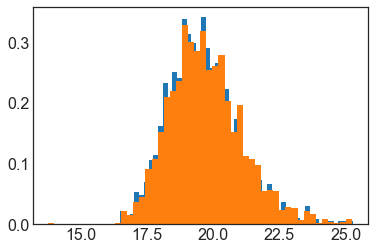

In [16]:
_=plt.hist(N_list2,density=True,bins=50)
_=plt.hist(NS_list2,density=True,bins=50)

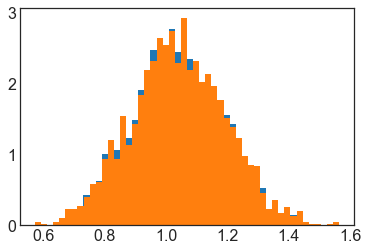

In [17]:
_=plt.hist(D_list2,density=True,bins=50)
_=plt.hist(DS_list2,density=True,bins=50)

In [31]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
dNS_list2_no_ol = reject_outliers(dNS_list2,m=3)

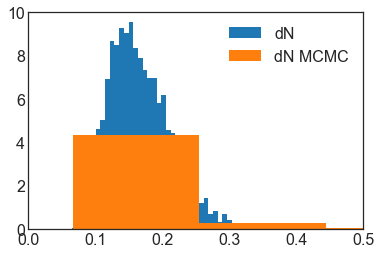

In [32]:
_=plt.hist(dN_list2,density=True,bins=50,label="dN")
_=plt.hist(dNS_list2_no_ol,density=True,bins=50,label="dN MCMC")
plt.xlim((0,0.5))
plt.legend()

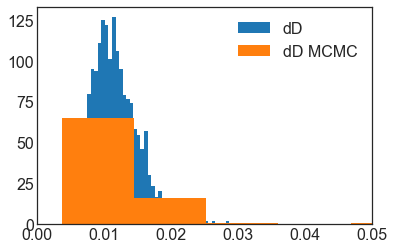

In [33]:
dDS_list2_no_ol = reject_outliers(dDS_list2,m=3)
_=plt.hist(dD_list2,density=True,bins=50,label="dD")
_=plt.hist(dDS_list2_no_ol,density=True,bins=50,label="dD MCMC")
plt.xlim((0,0.05))
plt.legend()

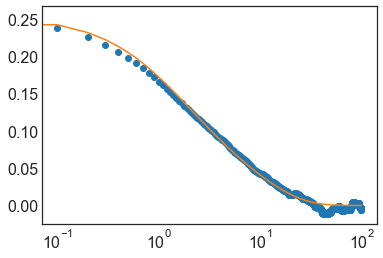

In [20]:
plt.semilogx(t,y,"o")
plt.semilogx(t,residual(result.params,t))

In [21]:
print("median of posterior probability distribution")
print('--------------------------------------------')
lm.report_fit(res.params)

median of posterior probability distribution
--------------------------------------------
[[Variables]]
    D:          0.98743431 +/- 0.01247782 (1.26%) (init = 0.9874135)
    N:          17.3260106 +/- 0.17067957 (0.99%) (init = 17.31784)
    __lnsigma:  0.18428463 +/- 0.02212032 (12.00%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.758
